# "An RL Approach for Inventory Management (Part 5)"

> Introduction to Function Approximation
- toc: true
- branch: master
- badges: false
- comments: true
- hide: false
- search_exclude: true
- metadata_key1: metadata_value1
- metadata_key2: metadata_value2
- image: images/InventoryManagement5.png
- categories: [Inventory_Management,   Function_Approximation,   Python]
- show_tags: true

In [1]:
# hide
# based on func_approx_simple_examples_ANNO.ipynb

## 1 Introduction to Function Approximation

When the state space becomes very large it is not feasible or even possible to make use of a tabular representation for a MDP (Markov Decision Process). Assume we have access to data in the form of a sequence of $n$ $(x, y)$ pairs:

$[(x_i,y_i)|1 \le i \le n]$

We can now attempt to estimate the probability density of $y$ conditional on $x$:

$f(y|x;w) = f(x;w)(y)$

The model-expected value of $y$ condition on $x$ is
$$
\hat y = \mathbb E_M[y|x] = ∫_{-∞}^{+\infty}y⋅f(y|x;w)⋅dy
$$
This is the function approximation's prediction for a given predictor variable $x$.

Some terminology:

$x \in \mathcal X$ is the *predictor* variable

$y \in \mathbb R$ is the *response* variable

$\hat y \in \mathbb R$ is the *prediction* variable

We are laying the groundwork for the development of software for *Approximate Dynamic Programming* as well as *Reinforcement Learning*. In this context $\mathbb E_M[y|x]$ provides an estimate for a:
- *value function*
  - $x$ represents the *state*
  - $y$ represents the *return*
- *policy*
  - $x$ represents the *state*
  - $y$ represents the *action*




In [2]:
#hide
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive"
base_dir = root_dir + '/Rao_CME241/RL-book'

Mounted at /content/gdrive


In [3]:
!python --version

Python 3.7.15


In [4]:
# hide
base_dir

'/content/gdrive/My Drive/Rao_CME241/RL-book'

In [5]:
# hide
import sys
sys.path

['/content',
 '/env/python',
 '/usr/lib/python37.zip',
 '/usr/lib/python3.7',
 '/usr/lib/python3.7/lib-dynload',
 '',
 '/usr/local/lib/python3.7/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.7/dist-packages/IPython/extensions',
 '/root/.ipython']

In [6]:
# hide
# sys.path.insert(0, f"{base_dir}/gen_utils"); sys.path
sys.path.append(f"{base_dir}"); sys.path

['/content',
 '/env/python',
 '/usr/lib/python37.zip',
 '/usr/lib/python3.7',
 '/usr/lib/python3.7/lib-dynload',
 '',
 '/usr/local/lib/python3.7/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.7/dist-packages/IPython/extensions',
 '/root/.ipython',
 '/content/gdrive/My Drive/Rao_CME241/RL-book']

We make use of the approach followed in http://web.stanford.edu/class/cme241/.

In [7]:
from __future__ import annotations
from typing import (Callable, Dict, Generic, Iterator, Iterable, List,
                    Mapping, Optional, Sequence, Tuple, TypeVar, overload)
from scipy.stats import norm
import numpy as np
from abc import ABC, abstractmethod
from collections import defaultdict
from dataclasses import dataclass, replace, field
import itertools

In [8]:
# hide
import rl.iterate_ANNO as iterate
from rl.gen_utils.plot_funcs import plot_list_of_curves

## 2 Example Model Data Generator

Let's setup a Data Model:
$$
\begin{aligned}
y &= \alpha + \beta_1 x_1 + \beta_2x_2 - \beta_3x_3 + \mathcal N(0, 0.3) \\
  &= 1 + 7x_1 - 2x_2 + 8x_3 + \mathcal N(0, 0.3)
\end{aligned}
$$

In [9]:
Triple = Tuple[float, float, float]
Aug_Triple = Tuple[float, float, float, float] #. augmented to prepend bias
DataSeq = Sequence[Tuple[Triple, float]] #. last float is for y

In [10]:
def example_model_data_generator() -> Iterator[Tuple[Triple, float]]:
    coeffs: Aug_Triple = (1., 7., -2., 8.)
    d = norm(loc=0., scale=0.3) #. normal distribution
    while True:
        pt: np.ndarray = np.random.randn(3)
        x_val: Triple = (pt[0], pt[1], pt[2])
        y_val: float = coeffs[0] + np.dot(coeffs[1:], pt) + \
            d.rvs(size=1)[0]
        yield (x_val, y_val)

In [11]:
data_gen: Iterator[Tuple[Triple, float]] = example_model_data_generator(); data_gen

<generator object example_model_data_generator at 0x7f229409e050>

Here are two ways to generate a specific number of data points:

In [12]:
mydata: DataSeq = [next(data_gen) for i in range(5)]; mydata

[((-1.676290585013634, -0.20330675764064765, 1.2409198966103707),
  -0.21621778064248845),
 ((0.8904228844005586, -1.0571951299100364, -1.3494027985154795),
  -1.4489959017682092),
 ((-0.08739558879596565, -0.6113476539743781, -0.7888914401285738),
  -4.6533727569600245),
 ((0.5708696624914378, -0.08369486644635994, -0.4633710969742489),
  1.7281828649292816),
 ((0.35765591694879084, 1.5036560666530643, 1.5036581693073041),
  12.660202897065746)]

In [13]:
mydata: DataSeq = list(itertools.islice(data_gen, 5)); mydata

[((1.0085819743173652, -1.268842630676064, -1.4728299417090938),
  -1.0929519721173804),
 ((0.15991749003209738, 0.7827078239138043, -0.23670087664912695),
  -0.8322309073547126),
 ((-0.03626491676513139, -0.22962172359834823, -0.16924944879064824),
  0.18957400851337064),
 ((-0.6166727432386784, -0.7364383180552759, -0.3245738309763991),
  -3.798426645143519),
 ((-0.4391577407965104, -0.00453671521783716, 0.5744307739264344),
  2.7594997387666362)]

### 2.1 Wrap in iterator
Now we wrap this generator in an iterator that returns a specified number of $(x,y)$ pairs:

In [14]:
def data_seq_generator(
    data_generator: Iterator[Tuple[Triple, float]],
    num_pts: int
) -> Iterator[DataSeq]:
    while True:
        pts: DataSeq = list(itertools.islice(data_generator, num_pts))
        yield pts

Configure it to generate train data:

In [15]:
data_gen: Iterator[Tuple[Triple, float]] = example_model_data_generator()

In [16]:
trn_num_pts: int = 10_000
trn_data_gen: Iterator[DataSeq] = data_seq_generator(
    data_generator=data_gen,
    num_pts=trn_num_pts
)
trn_data_gen

<generator object data_seq_generator at 0x7f2294105550>

In [17]:
next(trn_data_gen)[:5]

[((1.5141116022641963, 0.26998740175974173, -0.8685503731379335),
  4.089701120386119),
 ((1.0820407355967383, 0.3427549775851617, 1.1078679073305953),
  16.953635131550595),
 ((1.3241105796410801, 0.4075553673033938, -0.3144729996416032),
  7.088605383221274),
 ((-0.1839293455432471, -0.7972913552060831, -0.2851165267014572),
  -1.075779837694524),
 ((-0.675285392797429, -0.2880798686047421, 0.031245908101714626),
  -2.553426109315997)]

Configure it to generate test data:

In [18]:
tst_num_pts: int = 1_000
tst_data_gen: Iterator[DataSeq] = data_seq_generator(
    data_generator=data_gen,
    num_pts=tst_num_pts
)
tst_data_gen

<generator object data_seq_generator at 0x7f2293e02050>

In [19]:
next(tst_data_gen)[:5]

[((-0.10523271957547835, -2.170589448784764, 0.3010749843788246),
  7.277767867698341),
 ((-0.9983512260844962, 0.2934685812942415, -0.3282888943142292),
  -9.20126365132198),
 ((0.4995019622616231, -1.0578397350955713, 1.546176654939797),
  19.57345833833039),
 ((-0.10804134248084613, 1.1247507613502794, 0.9118420560826367),
  5.368526961464931),
 ((0.3780358510623769, -1.6538367411196908, -1.2552602675932416),
  -3.3073160186043435)]

In [20]:
tst_data: DataSeq = list(next(tst_data_gen))
len(tst_data)

1000

## 3. Implement $f(x; w)$

We define the next class to implement the function approximation $f(x;w)$. This class is generic in `X` to allow for arbitrary data types $\mathcal X$. An instance of this class approximates a function $x ↦ \mathbb R$. It enables:
- evaluation of $f(x;w)$ at specific predictor points
- updating with additional $(x,\mathbb R)$ data points

In [21]:
X = TypeVar('X') #. for arbitrary data types scriptX
F = TypeVar('F', bound='FunctionApprox')
SMALL_NUM = 1e-6

class FunctionApprox(ABC, Generic[X]):
    @abstractmethod
    def __add__(self: F, other: F) -> F:
        pass

    @abstractmethod
    def __mul__(self: F, scalar: float) -> F:
        pass

    @abstractmethod
    def objective_gradient(
        self: F,
        xy_vals_seq: Iterable[Tuple[X, float]],
        obj_deriv_out_fun: Callable[[Sequence[X], Sequence[float]], np.ndarray]
    ) -> Gradient[F]:
        pass

    @abstractmethod
    def evaluate(self, x_values_seq: Iterable[X]) -> np.ndarray:
        pass

    def __call__(self, x_value: X) -> float:
        return self.evaluate([x_value]).item()

    @abstractmethod
    def update_with_gradient(
        self: F,
        gradient: Gradient[F]
    ) -> F:
        pass

    def update(
        self: F,
        xy_vals_seq: Iterable[Tuple[X, float]]
    ) -> F:
        def deriv_func(x: Sequence[X], y: Sequence[float]) -> np.ndarray:
            return self.evaluate(x) - np.array(y)

        return self.update_with_gradient(
            self.objective_gradient(xy_vals_seq, deriv_func)
        )

    @abstractmethod
    def solve(
        self: F,
        xy_vals_seq: Iterable[Tuple[X, float]],
        error_tolerance: Optional[float] = None
    ) -> F:
        pass

    @abstractmethod
    def within(self: F, other: F, tolerance: float) -> bool:
        pass

    def iterate_updates(
        self: F,
        xy_seq_stream: Iterator[Iterable[Tuple[X, float]]]
    ) -> Iterator[F]:
        return iterate.accumulate(
            xy_seq_stream,
            lambda fa, xy: fa.update(xy),
            initial=self
        )

    def rmse(
        self,
        xy_vals_seq: Iterable[Tuple[X, float]]
    ) -> float:
        x_seq, y_seq = zip(*xy_vals_seq)
        errors: np.ndarray = self.evaluate(x_seq) - np.array(y_seq)
        return np.sqrt(np.mean(errors * errors))

    def argmax(self, xs: Iterable[X]) -> X:
        args: Sequence[X] = list(xs)
        return args[np.argmax(self.evaluate(args))]

The most important methods are:

- `solve`
  - Solve for the optimal internal parameters $w^*$ of the FunctionApprox such that the internal parameters are fitted to xy_vals_seq (assuming the complete data set of (x,y) pairs is available in the form of the given input xy_vals_seq data structure)
  - Parameters are fitted to within the input error_tolerance
  - Direct solve is also available (error_tolerance=None)
  - inputs
    - `xy_vals_seq: Iterable[Tuple[X, float]]`
    - `error_tolerance: Optional[float]=None`
  - output
    - `F`
      - the `FunctionApprox` $f(x;w^*)$
- `update`
  - Update the FunctionApprox's internal parameters $w$ defined in $f(x;w)$ based on incremental data supplied as $(x,y)$ pairs in the xy_vals_seq data structure.
  - inputs
    - `xy_vals_seq: Iterable[Tuple[X, float]]`  
      - the $(x,y)$ pairs in the current iteration
  - ouputs
    - `F`
      - the `FunctionApprox` $f(x;w)$ corresponding to the updated parameters
- `evaluate`
  - Computes the expected value of y for each x in x_values_seq, $\mathbb E_M[y|x]$
  - inputs
    - `x_values_seq: Iterable[X]`
  - output
    - np.ndarray
      - $\hat y = \mathbb E_M[y|x]$

The following two methods provide support to the `update` method:
- `objective_gradient`
  - Computes the gradient of an objective function of the self FunctionApprox with respect to the parameters in the internal representation of the FunctionApprox
  - The gradient is output in the form of a `Gradient[FunctionApprox]` whose internal parameters are equal to the gradient values
  - inputs
    - `xy_vals_seq: Iterable[Tuple[X, float]]`
    - `obj_deriv_out_fun: Callable[[Sequence[X], Sequence[float]], np.ndarray]`
        - the derivative of the objective with respect to the output
        (evaluate) of the `FunctionApprox`, when evaluated at a Sequence of
        x values and a Sequence of y values (to be obtained from `xy_vals_seq`)
  - output
    - `Gradient[F]`
- `update_with_gradient`
  - Update the internal parameters of self FunctionApprox
  - inputs
    - `gradient: Gradient[F]`
  - output
    - `F`


The following methods are useful for derived classes of `FunctionApprox`:

- `iterate_updates`
  - Given a stream (Iterator) of data sets of (x,y) pairs, perform a series of incremental updates to the internal parameters (using the `update` method), with each internal parameter update done for each data set of (x,y) pairs in the input stream of `xy_seq_stream`
  - inputs
    - `xy_seq_stream: Iterator[Iterable[Tuple[X, float]]]`
  - output
    - `Iterator[F]`
- `rmse`
  - The Root-Mean-Squared-Error between the `FunctionApprox`'s predictions (from `evaluate`) and the associated $y$ values
  - inputs
    - `xy_vals_seq: Iterable[Tuple[X, float]]`
  - output
    - `float` which is the RMSE
- `argmax`
  - Return the input `X` that maximizes the function being approximated.
  - inputs
    - xs: Iterable[X]
      - list of inputs to evaluate and maximize
  - output
    - `X`
      - the X that maximizes the function

The `Gradient` class holds the `FunctionApprox F`:

In [22]:
@dataclass(frozen=True)
class Gradient(Generic[F]):
    function_approx: F

    @overload
    def __add__(self, x: Gradient[F]) -> Gradient[F]:
        ...

    @overload
    def __add__(self, x: F) -> F:
        ...

    def __add__(self, x):
        if isinstance(x, Gradient):
            return Gradient(self.function_approx + x.function_approx)
        return self.function_approx + x

    def __mul__(self: Gradient[F], x: float) -> Gradient[F]:
        return Gradient(self.function_approx*x)

    def zero(self) -> Gradient[F]:
        return Gradient(self.function_approx*0.0)

## 3 LinearFunctionApprox

We need to transform a measurement of the state into a sequence of features 
$\phi_j$. For each $j$ we define a feature function

$\phi_j : \mathcal X \to \mathbb R$ for each $j=1,2,...,m$

We also define a sequence of feature functions

$\phi : \mathcal X \to \mathbb R^m$ so that
$\phi(x) = (\phi_1(x), \phi_2(x), ..., \phi_m(x)))$ for all $x \in \mathcal X$

We will treat $\phi(x)$ as a column vector. Another column vector is the parameters (weights) $w$ of the linear function approximation

$w = (w_1,w_2,...,w_m) \in \mathbb R^m$.

This leads to

$$
\begin{aligned}
\mathbb E_M[y|x] &= \phi(x)^\top ⋅ w \\
&= w^\top \cdot \phi(x) 
\end{aligned}
$$

Given that we have a sequence of data points $[x_i,y_i|1 \le i \le n]$, we define the *cross-entropy loss function* as

$$
\mathcal L(w) = \frac{1}{2n}\cdot \sum_{i=1}^n[w^⊤⋅\phi(x_i) - y_i]^2
$$

Similarly, we define the *regularized cross-entropy loss function* as

$$
\mathcal L(w) = \frac{1}{2n}(\sum_{i=1}^n[w^⊤⋅\phi(x_i) - y_i]^2) + \frac{1}{2} \cdot \lambda \cdot |w|^2
$$

using $L^2$ regularization.

The gradient of $\mathcal L(w)$ with respect to $w$ is then

$$
\nabla_w \mathcal L(w) = \frac{1}{n} ⋅ (\sum_{i=1}^n\phi(x_i)⋅[w^⊤⋅\phi(x_i) - y_i]) + \lambda \cdot w
$$

The update to the weights vector will be

$$
w_{t+1} = w_t - \alpha \cdot \mathcal G_{(x_t,y_t)}(w_t)
$$

where the gradient estimate $\mathcal G_{(x_t,y_t)}(w_t)$ at time $t$ is given by

$$
\mathcal G_{(x_t,y_t)}(w_t) = \frac{1}{n} ⋅ (\sum_{i=1}^{n_t} \phi(x_{t,i})⋅[w_t^⊤⋅\phi(x_{t,i}) - y_{t,i}]) + \lambda \cdot w_t
$$

with $\alpha_t$ the step size (also called learning rate) for the gradient descent at time $t$. To allow for convergence, $\alpha_t$ needs to be a suitable function of time $t$. The so-called ADAM algorithm will provide this (among others).

Next we implement the classes `AdamGradient` and `Weights`.



In [23]:
@dataclass(frozen=True)
class AdamGradient:
    learning_rate: float
    decay1: float
    decay2: float

    @staticmethod
    def default_settings() -> AdamGradient:
        return AdamGradient(
            learning_rate=0.001,
            decay1=0.9,
            decay2=0.999
        )

In [24]:
@dataclass(frozen=True)
class Weights:
    adam_gradient: AdamGradient #. ADAM parameters
    time: int #. how many times the weights have been updated
    weights: np.ndarray #. weight parameters of the function approximation
    adam_cache1: np.ndarray
    adam_cache2: np.ndarray

    @staticmethod
    def create(
        weights: np.ndarray,
        adam_gradient: AdamGradient = AdamGradient.default_settings(),
        adam_cache1: Optional[np.ndarray] = None,
        adam_cache2: Optional[np.ndarray] = None
    ) -> Weights:
        return Weights(
            adam_gradient=adam_gradient,
            time=0,
            weights=weights,
            adam_cache1=np.zeros_like(
                weights
            ) if adam_cache1 is None else adam_cache1,
            adam_cache2=np.zeros_like(
                weights
            ) if adam_cache2 is None else adam_cache2
        )

    def update(self, gradient: np.ndarray) -> Weights:
        time: int = self.time + 1
        new_adam_cache1: np.ndarray = self.adam_gradient.decay1* \
            self.adam_cache1 + (1 - self.adam_gradient.decay1)* gradient
        new_adam_cache2: np.ndarray = self.adam_gradient.decay2* \
            self.adam_cache2 + (1 - self.adam_gradient.decay2)*gradient**2
        corrected_m: np.ndarray = new_adam_cache1 / \
            (1 - self.adam_gradient.decay1**time)
        corrected_v: np.ndarray = new_adam_cache2 / \
            (1 - self.adam_gradient.decay2**time)
        new_weights: np.ndarray = self.weights - \
            self.adam_gradient.learning_rate*corrected_m / \
            (np.sqrt(corrected_v) + SMALL_NUM)
        return replace(
            self,
            time=time,
            weights=new_weights,
            adam_cache1=new_adam_cache1,
            adam_cache2=new_adam_cache2,
        )

    def within(self, other: Weights, tolerance: float) -> bool:
        return np.all(np.abs(self.weights - other.weights) <= tolerance).item()

Now we are ready to implement the `LinearFunctionApprox` class:

In [25]:
@dataclass(frozen=True)
class LinearFunctionApprox(FunctionApprox[X]):
    feature_functions: Sequence[Callable[[X], float]]
    regularization_coeff: float
    weights: Weights
    direct_solve: bool

    @staticmethod
    def create( #. factory method
        feature_functions: Sequence[Callable[[X], float]],
        adam_gradient: AdamGradient = AdamGradient.default_settings(),
        regularization_coeff: float = 0.,
        weights: Optional[Weights] = None,
        direct_solve: bool = True
    ) -> LinearFunctionApprox[X]:
        return LinearFunctionApprox(
            feature_functions=feature_functions,
            regularization_coeff=regularization_coeff,
            weights=Weights.create(
                adam_gradient=adam_gradient,
                weights=np.zeros(len(feature_functions))
            ) if weights is None else weights,
            direct_solve=direct_solve
        )

    def get_feature_values(self, x_values_seq: Iterable[X]) -> np.ndarray:
        return np.array(
            [[f(x) for f in self.feature_functions] for x in x_values_seq]
        )

    def objective_gradient(
        self,
        xy_vals_seq: Iterable[Tuple[X, float]],
        obj_deriv_out_fun: Callable[[Sequence[X], Sequence[float]], float]
    ) -> Gradient[LinearFunctionApprox[X]]:
        x_vals, y_vals = zip(*xy_vals_seq)
        obj_deriv_out: np.ndarray = obj_deriv_out_fun(x_vals, y_vals)
        features: np.ndarray = self.get_feature_values(x_vals)
        gradient: np.ndarray = \
            features.T.dot(obj_deriv_out) / len(obj_deriv_out) \
            + self.regularization_coeff * self.weights.weights
        return Gradient(replace(
            self,
            weights=replace(
                self.weights,
                weights=gradient
            )
        ))

    def __add__(self, other: LinearFunctionApprox[X]) -> \
            LinearFunctionApprox[X]:
        return replace(
            self,
            weights=replace(
                self.weights,
                weights=self.weights.weights + other.weights.weights
            )
        )

    def __mul__(self, scalar: float) -> LinearFunctionApprox[X]:
        return replace(
            self,
            weights=replace(
                self.weights,
                weights=self.weights.weights * scalar
            )
        )

    def evaluate(self, x_values_seq: Iterable[X]) -> np.ndarray:
        return np.dot(
            self.get_feature_values(x_values_seq),
            self.weights.weights
        )

    def update_with_gradient(
        self,
        gradient: Gradient[LinearFunctionApprox[X]]
    ) -> LinearFunctionApprox[X]:
        return replace(
            self,
            weights=self.weights.update(
                gradient.function_approx.weights.weights
            )
        )

    def solve(
        self,
        xy_vals_seq: Iterable[Tuple[X, float]],
        error_tolerance: Optional[float] = None
    ) -> LinearFunctionApprox[X]:
        if self.direct_solve:
            x_vals, y_vals = zip(*xy_vals_seq)
            feature_vals: np.ndarray = self.get_feature_values(x_vals)
            feature_vals_T: np.ndarray = feature_vals.T
            left: np.ndarray = np.dot(feature_vals_T, feature_vals) \
                + feature_vals.shape[0] * self.regularization_coeff * \
                np.eye(len(self.weights.weights))
            right: np.ndarray = np.dot(feature_vals_T, y_vals)
            ret = replace(
                self,
                weights=Weights.create(
                    adam_gradient=self.weights.adam_gradient,
                    weights=np.linalg.solve(left, right)
                )
            )
        else:
            tol: float = 1e-6 if error_tolerance is None else error_tolerance

            def done(
                a: LinearFunctionApprox[X],
                b: LinearFunctionApprox[X],
                tol: float = tol
            ) -> bool:
                return a.within(b, tol)

            ret = iterate.converged(
                self.iterate_updates(itertools.repeat(list(xy_vals_seq))),
                done=done
            )

        return ret

    def within(self, other: FunctionApprox[X], tolerance: float) -> bool:
        if isinstance(other, LinearFunctionApprox):
            return self.weights.within(other.weights, tolerance)

        return False

Some of the methods are:


- `get_feature_values`
  - input
    - `x_values_seq: Iterable[X]`
  - output
    - `np.ndarray`
      - the corresponding feature vectors $\phi(x) \in \mathbb R^m$
- `evaluate`
  - calculates $\mathbb E_M[y|x] = w^\top \cdot \phi(x)$
  - inputs
    - `x_values_seq: Iterable[X]`
  - output
    - `np.ndarray`
- `objective_gradient`
  - calculates
$$
\mathcal G_{(x_t,y_t)}(w_t) = \frac{1}{n} ⋅ (\sum_{i=1}^{n_t} \phi(x_{t,i})⋅[w_t^⊤⋅\phi(x_{t,i}) - y_{t,i}]) + \lambda \cdot w_t
$$
  - inputs
    - `xy_vals_seq: Iterable[Tuple[X, float]]`
    - `obj_deriv_out_fun: Callable[[Sequence[X], Sequence[float]], float]`
  - output
    - `Gradient[LinearFunctionApprox[X]]`
- `update_with_gradient`
  - updates the weights
  - returns a new LinearFunctionApprox
  - inputs
    - `gradient: Gradient[LinearFunctionApprox[X]]`
  - output
    - `LinearFunctionApprox[X]`
- `solve`
  - fits a model to the data
  - inputs
    - `xy_vals_seq: Iterable[Tuple[X, float]]`
    - `error_tolerance: Optional[float]=None`
  - output
    - `LinearFunctionApprox[X]`

### 3.1 Function to create a LinearFunctionApprox

Next we write a function to create a LinearFunctionApprox.

In [26]:
def feature_functions():
    return [lambda _: 1., lambda x: x[0], lambda x: x[1], lambda x: x[2]]

In [27]:
feature_functions()

[<function __main__.feature_functions.<locals>.<lambda>(_)>,
 <function __main__.feature_functions.<locals>.<lambda>(x)>,
 <function __main__.feature_functions.<locals>.<lambda>(x)>,
 <function __main__.feature_functions.<locals>.<lambda>(x)>]

In [28]:
def adam_gradient():
    return AdamGradient(
        learning_rate=0.1,
        decay1=0.9,
        decay2=0.999
    )

In [29]:
adam_gradient()

AdamGradient(learning_rate=0.1, decay1=0.9, decay2=0.999)

In [30]:
def get_linear_model() -> LinearFunctionApprox[Triple]:
    ffs = feature_functions()
    ag = adam_gradient()
    return LinearFunctionApprox.create(
         feature_functions=ffs,
         adam_gradient=ag,
         regularization_coeff=0.,
         direct_solve=True
    )

## 4 DNNApprox

Next, we will generalize the linear function approximation so that we can have non-linear functions. For this we use a simple deep neural network. It will be of the feed-forward, fully-connected type. A neural network consists of $L+1$ layers of neurons. The layers are numbered $l=0,1,2,...,L$ where
- $l=0$ is the input layer
- $l=1,2,...,L-1$ are the hidden layers
- $l=L$ is the output layer

Additionally,
- vector $i_l$ is the input to layer $l$
- vector $o_l$ is the output from layer $l$
- vector $x \in \mathcal X$ is the predictor variable
- vector $\phi$ is the feature variable
- scalar $y \in \mathbb R$ is the response variable
- scalar $\hat y$ is the estimated response variable
- model $M$ is the neural network
- $|o_l| \times |i_l|$ matrix $w_l$ is the parameters for layer $l$
- $|o_l|$ is the number of neurons in layer $l$
- $|o_L|=1$ due to our restriction on only scalar values for $y$
- $s_l = w_l \cdot i_l$ is the linear transformation in layer $l$ for all $l=1,2,...,L$
- $g_l$ is the activation function for layer $l$

Some conventions on linear algebra:
- all vectors treated as column vectors
- gradient of a vector of dimension $m$ with respect to a vector of dimension $n$ will be a $m \times n$ Jacobian matrix
- $|v|$ is the dimension of vector $v$

### 4.1 Forward Propagation

The calculation provided by a neural network to transform a predictor variable $x$ into an estimate $\hat y$ of the response variable $y$, is known as *forward propagation*. This calculation is captured by the following three equations which establish relationsips among the above variables:

$$
i_0 = \phi(x) \in \mathbb R^m, \quad i_{l+1} = o_l, \quad o_L = \mathbb E_M[y|x] \quad \text{for all} \quad l = 0,1,...,L-1 \qquad (4.1)
$$

$$
s_l = w_l \cdot i_l \text{   for all   }l=0,1,...,L \qquad (4.2)
$$

$$
o_l = g_l(s_l) \text{   for all   }l=0,1,...,L \qquad (4.2)
$$

This calculation will be implemented by means of the `evaluate` method below.

### 4.2 Loss Gradient

Next we want an expression for the cross-entropy loss gradient with respect to the parameters for each of the layers, i.e. $∇_{w_l} \mathcal L$. The chain rule leads to the expression

$$
\begin{aligned}
∇_{w_l} \mathcal L &= (\nabla_{s_l}\mathcal L)^\top \cdot \nabla_{w_l}s_l \\
&= P_l^\top \cdot \nabla_{w_l}s_l \\
&= P_l \cdot i_l^\top 
\end{aligned}
$$
for all $l=0,1,...,L$ where we define $P_l = \nabla_{s_l} \mathcal L$, and

$P_l = (w_{l+1}^\top \cdot P_{l+1}) \circ g_l'(s_l)$

where the symbol $\circ$ represents the point-wise product of two vectors, also known as the *Hadamard Product*. We will not prove the previous theorem. 

Adding $L^2$ regularization gives:

$\nabla_{w_l} \mathcal L = P_l \cdot i_l^\top + \lambda_l \cdot w_l$ for all $l=0,1,...,L$

### 4.3 Architecture of the Neural Network

The following class captures the architecture of an implemented neural network.

In [31]:
@dataclass(frozen=True)
class DNNSpec:
    neurons: Sequence[int]
    bias: bool
    hidden_activation: Callable[[np.ndarray], np.ndarray]
    hidden_activation_deriv: Callable[[np.ndarray], np.ndarray]
    output_activation: Callable[[np.ndarray], np.ndarray]
    output_activation_deriv: Callable[[np.ndarray], np.ndarray]

- `neurons`
  - a sequence of length $L$
  - the elements of the sequence are $|o_0|, |o_1|, ..., |o_{L-1}|$
  - $|o_L|$ is not captured as we know it will always have a single neuron
- `bias`
  - a boolean
  - if `bias` is `True`:
    - $|i_l| = |o_{l-1}| + 1$ for all $l=1,2,...,L$
    - we have to prepend matrix $w_l$ with a vector of all 1's
- `hidden_activation` $g_l(s_l)$
  - a function from `np.array` to `np.array`
    - $s_l$ is the input
    - $g_l(s_l)$ is the output 
  - $g_l(s_l) \text{   for all   }l=0,1,...,L-1$
- `hidden_activation_deriv` $h_l(o_l)$
  - a function from `np.array` to `np.array`
    - $o_l$ is the input
    - $h_l(o_l)$ is the output 
  - $h_l(o_l) = h_l(g(s_l)) = g_l'(s_l) \text{   for all   }l=0,1,...,L-1$

- `output_activation` $g_L(s_L)$
  - a function from `np.array` to `np.array`
    - $s_L$ is the input
    - $g_L(s_L)$ is the output 
  - $g_L(s_L)$
- `output_activation_deriv` $h_L(o_L)$
  - a function from `np.array` to `np.array`
    - $o_L$ is the input
    - $h_L(o_L)$ is the output 
  - $h_L(o_L) = h_L(g(s_L)) = g_L'(s_L)$  

### 4.4 Deep Neural Network Approximation

The next class implements the Deep Neural Network Approximation:

In [32]:
@dataclass(frozen=True)
class DNNApprox(FunctionApprox[X]):
    feature_functions: Sequence[Callable[[X], float]]
    dnn_spec: DNNSpec
    regularization_coeff: float
    weights: Sequence[Weights]

    @staticmethod
    def create( #. factory method
        feature_functions: Sequence[Callable[[X], float]],
        dnn_spec: DNNSpec,
        adam_gradient: AdamGradient = AdamGradient.default_settings(),
        regularization_coeff: float = 0.,
        weights: Optional[Sequence[Weights]] = None
    ) -> DNNApprox[X]:
        if weights is None:
            inputs: Sequence[int] = [len(feature_functions)] + \
                [n + (1 if dnn_spec.bias else 0)
                 for i, n in enumerate(dnn_spec.neurons)]
            outputs: Sequence[int] = list(dnn_spec.neurons) + [1]
            wts = [Weights.create(
                weights=np.random.randn(output, inp)/np.sqrt(inp),
                adam_gradient=adam_gradient
            ) for inp, output in zip(inputs, outputs)]
        else:
            wts = weights

        return DNNApprox(
            feature_functions=feature_functions,
            dnn_spec=dnn_spec,
            regularization_coeff=regularization_coeff,
            weights=wts
        )

    def get_feature_values(self, x_values_seq: Iterable[X]) -> np.ndarray:
        return np.array(
            [[f(x) for f in self.feature_functions] for x in x_values_seq]
        )

    def forward_propagation(
        self,
        x_values_seq: Iterable[X]
    ) -> Sequence[np.ndarray]:
        inp: np.ndarray = self.get_feature_values(x_values_seq)
        ret: List[np.ndarray] = [inp]
        for w in self.weights[:-1]:
            out: np.ndarray = self.dnn_spec.hidden_activation(
                np.dot(inp, w.weights.T)
            )
            if self.dnn_spec.bias:
                inp = np.insert(out, 0, 1., axis=1)
            else:
                inp = out
            ret.append(inp)
        ret.append(
            self.dnn_spec.output_activation(
                np.dot(inp, self.weights[-1].weights.T)
            )[:, 0]
        )
        return ret

    def evaluate(self, x_values_seq: Iterable[X]) -> np.ndarray:
        return self.forward_propagation(x_values_seq)[-1]

    def backward_propagation(
        self,
        fwd_prop: Sequence[np.ndarray],
        obj_deriv_out: np.ndarray
    ) -> Sequence[np.ndarray]:
        deriv: np.ndarray = obj_deriv_out.reshape(1, -1)
        back_prop: List[np.ndarray] = [np.dot(deriv, fwd_prop[-1]) /
                                       deriv.shape[1]]
        for i in reversed(range(len(self.weights) - 1)):
            deriv = np.dot(self.weights[i + 1].weights.T, deriv) * \
                self.dnn_spec.hidden_activation_deriv(fwd_prop[i + 1].T)
            if self.dnn_spec.bias:
                deriv = deriv[1:]
            back_prop.append(np.dot(deriv, fwd_prop[i]) / deriv.shape[1])
        return back_prop[::-1]

    def objective_gradient(
        self,
        xy_vals_seq: Iterable[Tuple[X, float]],
        obj_deriv_out_fun: Callable[[Sequence[X], Sequence[float]], float]
    ) -> Gradient[DNNApprox[X]]:
        x_vals, y_vals = zip(*xy_vals_seq)
        obj_deriv_out: np.ndarray = obj_deriv_out_fun(x_vals, y_vals)
        fwd_prop: Sequence[np.ndarray] = self.forward_propagation(x_vals)[:-1]
        gradient: Sequence[np.ndarray] = \
            [x + self.regularization_coeff * self.weights[i].weights
             for i, x in enumerate(self.backward_propagation(
                 fwd_prop=fwd_prop,
                 obj_deriv_out=obj_deriv_out
             ))]
        return Gradient(replace(
            self,
            weights=[replace(w, weights=g) for
                     w, g in zip(self.weights, gradient)]
        ))

    def __add__(self, other: DNNApprox[X]) -> DNNApprox[X]:
        return replace(
            self,
            weights=[replace(w, weights=w.weights + o.weights) for
                     w, o in zip(self.weights, other.weights)]
        )

    def __mul__(self, scalar: float) -> DNNApprox[X]:
        return replace(
            self,
            weights=[replace(w, weights=w.weights * scalar)
                     for w in self.weights]
        )

    def update_with_gradient(
        self,
        gradient: Gradient[DNNApprox[X]]
    ) -> DNNApprox[X]:
        return replace(
            self,
            weights=[w.update(g.weights) for w, g in
                     zip(self.weights, gradient.function_approx.weights)]
        )

    def solve(
        self,
        xy_vals_seq: Iterable[Tuple[X, float]],
        error_tolerance: Optional[float] = None
    ) -> DNNApprox[X]:
        tol: float = 1e-6 if error_tolerance is None else error_tolerance

        def done(
            a: DNNApprox[X],
            b: DNNApprox[X],
            tol: float = tol
        ) -> bool:
            return a.within(b, tol)

        return iterate.converged(
            self.iterate_updates(itertools.repeat(list(xy_vals_seq))),
            done=done
        )

    def within(self, other: FunctionApprox[X], tolerance: float) -> bool:
        if isinstance(other, DNNApprox):
            return all(w1.within(w2, tolerance)
                       for w1, w2 in zip(self.weights, other.weights))
        else:
            return False

- attributes
  - `feature_functions: Sequence[Callable[[X], float]]`
     - implements $\phi_j : \mathcal X \to \mathbb R$ for all $j=1,2,...,m$
  - `dnn_spec: DNNSpec`
  - `regularization_coeff: float`
    - $\lambda$ for the weights across all the layers
  - `weights: Sequence[Weights]`
    - implements the weights of all the layers
- methods
  - `get_feature_values`
    - inputs
      - `x_values_seq: Iterable[X]`
    - output
      - `np.ndarray`
        - $n \times m$ matrix where $n$ is the number of $x$'s in the mini-batch and $m$ is $|\phi(x)|$
  - `forward_propagation`
    - implements (4.1), (4.2), and (4.3)
    - input
      - `x_values_seq: Iterable[X]`
        - the predictor points
        - $n$ $i_0$-vectors ($n \times |i_0|$)
    - output 
      - `Sequence[np.ndarray]`
      - the activations
      - list of length $L+2$
        - first $L+2$ elements are 2-D arrays where each 2D-array consists of
          - $n$ $i_l$-vectors ($n \times |i_l|$)
        - last element is the output of the DNN ($n \times |i_L|$)
  - `evaluate`
    - input
      - `x_values_seq: Iterable[X]`
        - the predictor points
        - $n$ $i_0$-vectors ($n \times |i_0|$)
    - output
      - `np.ndarray`
      - last element of the list returned by `forward_propagation` ($o_L=\mathbb E_M[y|x]$)
  - `backward_propagation`
    - inputs
      - `fwd_prop: Sequence[np.ndarray]`
        - result of forward propagation (without
        the final output), a sequence of L 2-D np.ndarrays of the DNN
      - `obj_deriv_out: np.ndarray`
        - derivative of the objective
        function with respect to the linear predictor of the final layer
    - output
      - `Sequence[np.ndarray]`
        - list (of length L+1) of |o_l| x |i_l| 2-D arrays, i.e., same as the type of self.weights.weights
        - computes the gradient (with respect to weights) of the objective where the output layer activation function is the canonical link function of the conditional distribution of y|x
  - `objective_gradient`
    - inputs
      - `xy_vals_seq: Iterable[Tuple[X, float]]`
      - `obj_deriv_out_fun: Callable[[Sequence[X], Sequence[float]], float]`
    - output
      - $\nabla_{w_l}Obj$ for all $l=0,1,...,L$
  - `update_with_gradient`
    - input:
      - `gradient: Gradient[DNNApprox[X]]`
    - output:
      - `DNNApprox[X]`
  - `solve`
    - inputs
      - `xy_vals_seq: Iterable[Tuple[X, float]]`
      - `error_tolerance: Optional[float]=None`
    - output
      - `DNNApprox[X]`
    - uses `iterate_updates` and `within` to perform a best-fit of the weights
$$
$$

### 4.5 Function to create a DNNApprox

Next we write a function to create a DNNApprox with 1 hidden layer having 2 neurons. We also add some regularization.

In [33]:
def get_dnn_model() -> DNNApprox[Triple]:
    ffs = feature_functions()
    ag = adam_gradient()

    def relu(arg: np.ndarray) -> np.ndarray:
        return np.vectorize(lambda x: x if x > 0. else 0.)(arg)

    def relu_deriv(res: np.ndarray) -> np.ndarray:
        return np.vectorize(lambda x: 1. if x > 0. else 0.)(res)

    def identity(arg: np.ndarray) -> np.ndarray:
        return arg

    def identity_deriv(res: np.ndarray) -> np.ndarray:
        return np.ones_like(res)

    ds = DNNSpec(
        neurons=[2],
        bias=True,
        hidden_activation=relu,
        hidden_activation_deriv=relu_deriv,
        output_activation=identity,
        output_activation_deriv=identity_deriv
    )

    return DNNApprox.create(
        feature_functions=ffs,
        dnn_spec=ds,
        adam_gradient=ag,
        regularization_coeff=0.05
    )

In [34]:
get_dnn_model()

DNNApprox(feature_functions=[<function feature_functions.<locals>.<lambda> at 0x7f22a03227a0>, <function feature_functions.<locals>.<lambda> at 0x7f22a0322e60>, <function feature_functions.<locals>.<lambda> at 0x7f22a0322560>, <function feature_functions.<locals>.<lambda> at 0x7f22a0322440>], dnn_spec=DNNSpec(neurons=[2], bias=True, hidden_activation=<function get_dnn_model.<locals>.relu at 0x7f22a0322050>, hidden_activation_deriv=<function get_dnn_model.<locals>.relu_deriv at 0x7f22a0322c20>, output_activation=<function get_dnn_model.<locals>.identity at 0x7f22a0322dd0>, output_activation_deriv=<function get_dnn_model.<locals>.identity_deriv at 0x7f22a0322d40>), regularization_coeff=0.05, weights=[Weights(adam_gradient=AdamGradient(learning_rate=0.1, decay1=0.9, decay2=0.999), time=0, weights=array([[ 0.1933681 ,  0.38027881, -0.00492979, -0.76650108],
       [-0.10652202, -0.0332175 , -0.17239005,  0.89441099]]), adam_cache1=array([[0., 0., 0., 0.],
       [0., 0., 0., 0.]]), adam_ca

## 5 Direct Solve for LinearFunctionApprox

Next, we do a direct solve on a LinearFunctionApprox instance.

In [35]:
direct_solve_lfap: LinearFunctionApprox[Triple] = \
    get_linear_model().solve(next(trn_data_gen))
direct_solve_rmse: float = direct_solve_lfap.rmse(tst_data)
print(f"Linear Model Direct Solve RMSE = {direct_solve_rmse:.3f}")
print("-----------------------------")

Linear Model Direct Solve RMSE = 0.302
-----------------------------


## 6 Stochastic Gradient Descent

Next we want to do SGD (Stochastic Gradient Descent) with each of the two function approximations so that we can compare how their RMSE (Root-Mean-Square-Errors) decline with the number of iterations.

In [36]:
trn_iterations: int = 200

In [37]:
print("Linear Model SGD")
print("----------------")
lfap_rmse_seq: List[float] = []
lfap_weights_seq: List[Weights] = [] #.
for lfap in itertools.islice(
    get_linear_model().iterate_updates(trn_data_gen),
    trn_iterations
):
    this_rmse: float = lfap.rmse(tst_data)
    lfap_rmse_seq.append(this_rmse)
    lfap_weights_seq.append(lfap.weights) #.
    iter: int = len(lfap_rmse_seq)
    print(f"Iteration {iter:d}: RMSE = {this_rmse:.3f}")

Linear Model SGD
----------------
Iteration 1: RMSE = 10.803
Iteration 2: RMSE = 10.641
Iteration 3: RMSE = 10.481
Iteration 4: RMSE = 10.322
Iteration 5: RMSE = 10.164
Iteration 6: RMSE = 10.008
Iteration 7: RMSE = 9.854
Iteration 8: RMSE = 9.702
Iteration 9: RMSE = 9.552
Iteration 10: RMSE = 9.403
Iteration 11: RMSE = 9.256
Iteration 12: RMSE = 9.110
Iteration 13: RMSE = 8.966
Iteration 14: RMSE = 8.824
Iteration 15: RMSE = 8.682
Iteration 16: RMSE = 8.542
Iteration 17: RMSE = 8.403
Iteration 18: RMSE = 8.264
Iteration 19: RMSE = 8.127
Iteration 20: RMSE = 7.990
Iteration 21: RMSE = 7.854
Iteration 22: RMSE = 7.719
Iteration 23: RMSE = 7.586
Iteration 24: RMSE = 7.452
Iteration 25: RMSE = 7.320
Iteration 26: RMSE = 7.190
Iteration 27: RMSE = 7.060
Iteration 28: RMSE = 6.931
Iteration 29: RMSE = 6.804
Iteration 30: RMSE = 6.677
Iteration 31: RMSE = 6.552
Iteration 32: RMSE = 6.428
Iteration 33: RMSE = 6.306
Iteration 34: RMSE = 6.184
Iteration 35: RMSE = 6.064
Iteration 36: RMSE = 5.9

In [38]:
print("DNN Model SGD")
print("-------------")
dfap_rmse_seq: List[float] = []
dfap_weights_seq: List[Weights] = [] #.
for dfap in itertools.islice(
    get_dnn_model().iterate_updates(trn_data_gen),
    trn_iterations
):
    this_rmse: float = dfap.rmse(tst_data)
    dfap_rmse_seq.append(this_rmse)
    dfap_weights_seq.append(dfap.weights) #.
    iter: int = len(dfap_rmse_seq)
    print(f"Iteration {iter:d}: RMSE = {this_rmse:.3f}")

DNN Model SGD
-------------
Iteration 1: RMSE = 9.987
Iteration 2: RMSE = 9.761
Iteration 3: RMSE = 9.501
Iteration 4: RMSE = 9.208
Iteration 5: RMSE = 8.881
Iteration 6: RMSE = 8.522
Iteration 7: RMSE = 8.133
Iteration 8: RMSE = 7.718
Iteration 9: RMSE = 7.279
Iteration 10: RMSE = 6.820
Iteration 11: RMSE = 6.343
Iteration 12: RMSE = 5.853
Iteration 13: RMSE = 5.353
Iteration 14: RMSE = 4.855
Iteration 15: RMSE = 4.367
Iteration 16: RMSE = 3.900
Iteration 17: RMSE = 3.467
Iteration 18: RMSE = 3.085
Iteration 19: RMSE = 2.773
Iteration 20: RMSE = 2.563
Iteration 21: RMSE = 2.479
Iteration 22: RMSE = 2.518
Iteration 23: RMSE = 2.641
Iteration 24: RMSE = 2.785
Iteration 25: RMSE = 2.895
Iteration 26: RMSE = 2.939
Iteration 27: RMSE = 2.909
Iteration 28: RMSE = 2.807
Iteration 29: RMSE = 2.652
Iteration 30: RMSE = 2.462
Iteration 31: RMSE = 2.259
Iteration 32: RMSE = 2.070
Iteration 33: RMSE = 1.918
Iteration 34: RMSE = 1.820
Iteration 35: RMSE = 1.781
Iteration 36: RMSE = 1.795
Iteration

### 6.1 RMSE comparison

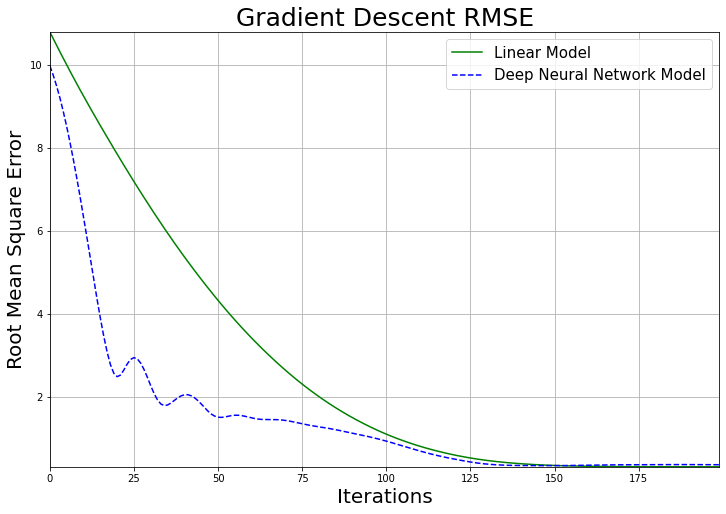

In [39]:
x_vals = range(trn_iterations)
plot_list_of_curves(
    list_of_x_vals=[x_vals, x_vals],
    list_of_y_vals=[lfap_rmse_seq, dfap_rmse_seq],
    list_of_colors=["g-", "b--"],
    list_of_curve_labels=["Linear Model", "Deep Neural Network Model"],
    x_label="Iterations",
    y_label="Root Mean Square Error",
    title="Gradient Descent RMSE"
)

### 6.2 Weights convergence

It will also be interesting to see how the weights converge during training.

In [40]:
lfap_arrays = [ws.weights for ws in lfap_weights_seq]
dfap_arrays_0 = [ws[0].weights[0] for ws in dfap_weights_seq]
dfap_arrays_1 = [ws[0].weights[1] for ws in dfap_weights_seq]

In [41]:
lfap_weights_lst = [list(arr) for arr in zip(*lfap_arrays)]
dfap_weights_lst_0 = [list(arr) for arr in zip(*dfap_arrays_0)]
dfap_weights_lst_1 = [list(arr) for arr in zip(*dfap_arrays_1)]

In [42]:
weight_names = ['alpha', 'beta_1', 'beta_2', 'beta_3']

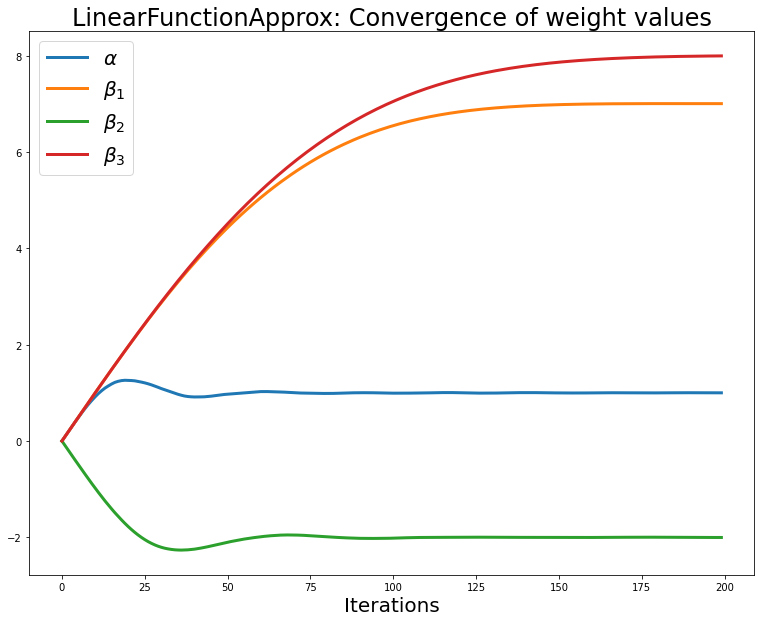

In [43]:
import matplotlib.pyplot as plt
fig,axs = plt.subplots(figsize=(13,10))
axs.set_xlabel('Iterations', fontsize=20)
axs.set_title(f'LinearFunctionApprox: Convergence of weight values', fontsize=24)
for i in range(len(lfap_weights_lst)):
  axs.plot(lfap_weights_lst[i], label=f'$\{weight_names[i]}$', linewidth=3.0)
axs.legend(fontsize=20);

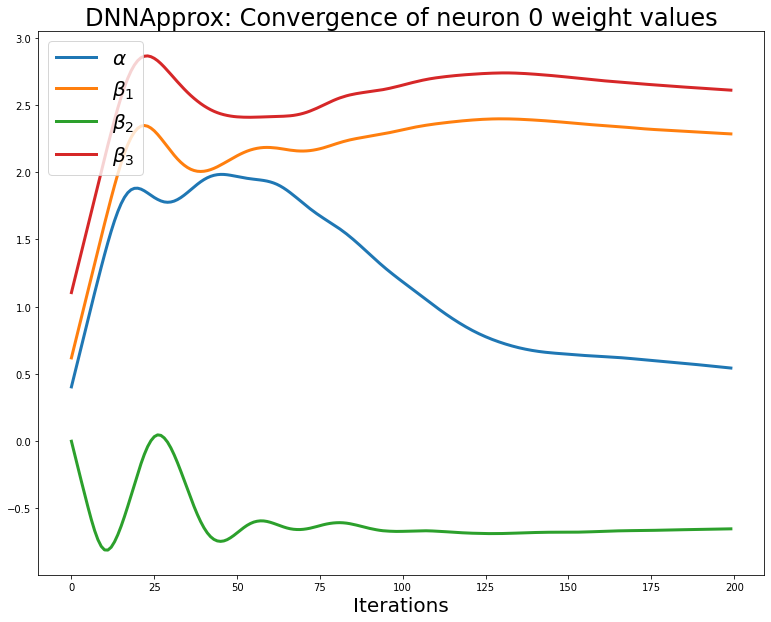

In [44]:
import matplotlib.pyplot as plt
fig,axs = plt.subplots(figsize=(13,10))
axs.set_xlabel('Iterations', fontsize=20)
axs.set_title(f'DNNApprox: Convergence of neuron 0 weight values', fontsize=24)
for i in range(len(dfap_weights_lst_0)):
  axs.plot(dfap_weights_lst_0[i], label=f'$\{weight_names[i]}$', linewidth=3.0)
axs.legend(fontsize=20);

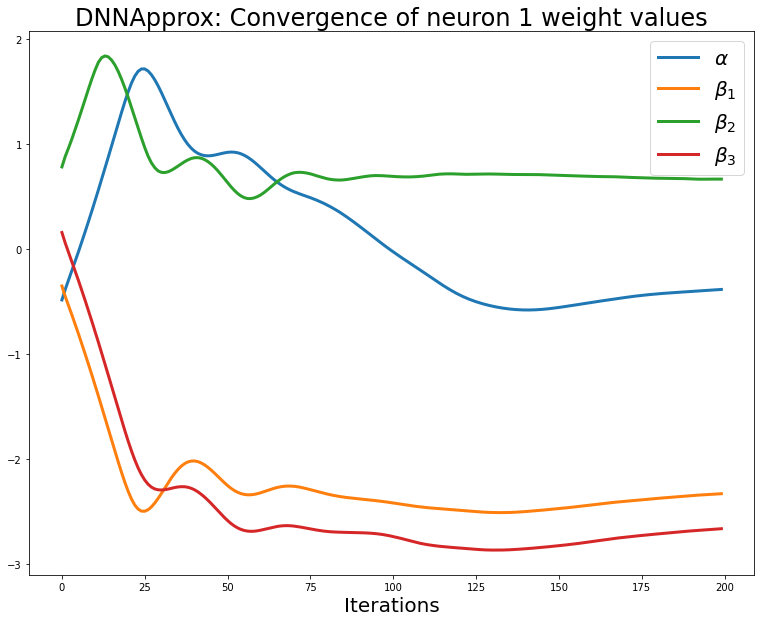

In [45]:
import matplotlib.pyplot as plt
fig,axs = plt.subplots(figsize=(13,10))
axs.set_xlabel('Iterations', fontsize=20)
axs.set_title(f'DNNApprox: Convergence of neuron 1 weight values', fontsize=24)
for i in range(len(dfap_weights_lst_1)):
  axs.plot(dfap_weights_lst_1[i], label=f'$\{weight_names[i]}$', linewidth=3.0)
axs.legend(fontsize=20);